In [16]:
import pickle
import re
import string
from pathlib import Path
from typing import Dict, Any, Union

import joblib
import numpy
import numpy as np
from hyperopt import STATUS_OK, hp, Trials, fmin, tpe
from matplotlib import pyplot as plt
from numpy import asarray, average, dtype, ndarray
from pandas import read_csv, DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import roc_curve, balanced_accuracy_score, auc, precision_score, recall_score, f1_score, \
    classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.contrib.itertools import product
from xgboost import XGBClassifier

from utils import tokenizer_transform, replace_text_components, clean_text

In [38]:
# Constant Numbers
CV = 5
RETRAIN = True
OVERWRITE = False
RANDOM_STATE = 42
TEST_SIZE = 2e-1

# Paths
GLOVE_6B_50D_TXT = Path('models/glove-embeddings/glove.6B.50d.txt')
GLOVE_6B_100D_TXT = Path('models/glove-embeddings/glove.6B.100d.txt')
GLOVE_6B_200D_TXT = Path('models/glove-embeddings/glove.6B.200d.txt')
GLOVE_6B_300D_TXT = Path('models/glove-embeddings/glove.6B.300d.txt')

MODELS_DICT_PKL = Path('models/models_dict.pkl')
OPTIMAL_MODEL_PKL = Path('models/filter.pkl')

ANASTASIA_CSV = Path('data/anastasia.csv')
THREAT_TWEETS_PKL = Path('data/tweets-dataset-for-cyberattack-detection/filter_train.pkl')

In [3]:
MODELS_INFO = [
    {'name': 'SBERT', 'model-path': 'sentence-transformers/all-mpnet-base-v2', 'embedding-dim': None},
    {'name': 'DistilBERT', 'model-path': 'sentence-transformers/all-distilroberta-v1', 'embedding-dim': None},
    {'name': 'GloVe.6B.50D', 'model-path': GLOVE_6B_50D_TXT, 'embedding-dim': 50},
    {'name': 'GloVe.6B.100D', 'model-path': GLOVE_6B_100D_TXT, 'embedding-dim': 100},
    {'name': 'GloVe.6B.200D', 'model-path': GLOVE_6B_200D_TXT, 'embedding-dim': 200},
    {'name': 'GloVe.6B.300D', 'model-path': GLOVE_6B_300D_TXT, 'embedding-dim': 300},
    #{'name': 'GloVe.42B.300D', 'model-path': GLOVE_42B_300D_TXT, 'embedding-dim': 300},
    #{'name': 'GloVe.840B.300D', 'model-path': GLOVE_840B_300D_TXT, 'embedding-dim': 300},
    #{'name': 'GloVe.Twitter.27B.25D', 'model-path': GLOVE_TWITTER_27B_25D_TXT, 'embedding-dim': 25},
    #{'name': 'GloVe.Twitter.27B.50D', 'model-path': GLOVE_TWITTER_27B_50D_TXT, 'embedding-dim': 50},
    #{'name': 'GloVe.Twitter.27B.100D', 'model-path': GLOVE_TWITTER_27B_100D_TXT, 'embedding-dim': 100},
    #{'name': 'GloVe.Twitter.27B.200D', 'model-path': GLOVE_TWITTER_27B_200D_TXT, 'embedding-dim': 200}
]

In [4]:
def load_word2vec_dict(model_path: Path, embedding_dim: int) -> dict[Union[str, list[str]], ndarray[Any, dtype]]:
    embeddings_dict = {}

    f = open(model_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = ' '.join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()

    return embeddings_dict

In [5]:
def preprocess_texts(list_str, model_path, embedding_dim):
    if embedding_dim is None:
        return tokenizer_transform(
            x=list_str,
            embedder_addr=model_path,
            preprocessing_list=[replace_text_components, clean_text]
        )

    word2vec_dict = load_word2vec_dict(
        model_path=model_path,
        embedding_dim=embedding_dim
    )
    list_embedded_str = numpy.zeros((len(list_str), embedding_dim))

    for i, text in enumerate(list_str):
        tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)

        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue

    return list_embedded_str

In [6]:
def train_classifier(
        x: ndarray, y: ndarray, cv: int = 1, random_state: int = None, test_size: float = 0.2, model_type: str = None
) -> Dict[str, Union[float, Any]]:
    classifier_dict = {
        'cv-accuracy': 0,
        'model': None
    }

    if model_type == 'nb':
        classifier = GaussianNB()
    elif model_type == 'svm':
        classifier = SVC()
    elif model_type == 'rf':
        classifier = RandomForestClassifier(
            n_estimators=151,
            max_depth=15,
            min_samples_split=21,
            min_samples_leaf=10,
            bootstrap=False,
            random_state=RANDOM_STATE,
            verbose=0
        )
    elif model_type == 'mlp':
        classifier = MLPClassifier()
    elif model_type == 'dt':
        classifier = DecisionTreeClassifier()
    elif model_type == 'gp':
        classifier = GaussianProcessClassifier()
    elif model_type == 'xgb':
        classifier = XGBClassifier()
    else:
        return classifier_dict

    x_train, x_test, y_train, y_test = train_test_split(
        x, y,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=y
    )

    classifier_dict['cv-accuracy'] = average(a=cross_val_score(
        estimator=classifier,
        X=x,
        y=y,
        scoring='balanced_accuracy',
        cv=cv
    ))

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    classifier.fit(X=x_train, y=y_train)

    y_predicted_test = classifier.predict(X=x_test)
    y_predicted_train = classifier.predict(X=x_train)
    fpr_train, tpr_train, _ = roc_curve(y_true=y_train, y_score=y_predicted_train)
    fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=y_predicted_test)

    classifier_dict['model'] = classifier
    classifier_dict['train'] = {
        'accuracy': balanced_accuracy_score(y_true=y_train, y_pred=y_predicted_train),
        'precision': precision_score(y_true=y_train, y_pred=y_predicted_train),
        'recall': recall_score(y_true=y_train, y_pred=y_predicted_train),
        'f1': f1_score(y_true=y_train, y_pred=y_predicted_train),
        'fpr': fpr_train,
        'tpr': tpr_train,
        'auc': auc(x=fpr_train, y=tpr_train)
    }
    classifier_dict['test'] = {
        'accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_predicted_test),
        'precision': precision_score(y_true=y_test, y_pred=y_predicted_test),
        'recall': recall_score(y_true=y_test, y_pred=y_predicted_test),
        'f1': f1_score(y_true=y_test, y_pred=y_predicted_test),
        'fpr': fpr_test,
        'tpr': tpr_test,
        'auc': auc(x=fpr_test, y=tpr_test)
    }

    return classifier_dict

In [7]:
with open(THREAT_TWEETS_PKL, 'rb') as f:
    threat_tweets = pickle.load(file=f)

threat_tweets.head()

,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate
13289,b'5b937e1dbb325e521c5aec2a',2018-09-08 07:45:30+00:00,1038332487162884096,False,"Unfortunately, to expel a foreigner is a sover...",{'created_at': 'Sat Sep 08 07:45:30 +0000 2018...,general,"{'usage': {'text_units': 1, 'text_characters':...",irrelevant,['https://twitter.com/i/web/status/10383324871...,https://twitter.com/i/web/status/1038332487162...,True
3916,b'5b912082bb325e7007186f4a',2018-09-06 12:41:38+00:00,1037682232989769729,False,This bull poop!🙏🏻❤️🇺🇸,{'created_at': 'Thu Sep 06 12:41:38 +0000 2018...,general,"{'usage': {'text_units': 1, 'text_characters':...",NaN,[],NaN,NaN
20282,b'5b976657bb325e7a2e19a252',2018-09-11 06:53:10+00:00,1039406480057937920,True,Ethical Hacking - SQL Injection Attack limited...,{'created_at': 'Tue Sep 11 06:53:10 +0000 2018...,general,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://www.udemy.com/sql-injection-ethical-...,https://www.udemy.com/course/sql-injection-eth...,True
815,b'5b8ca25fbb325e2996c66737',2018-09-03 02:54:22+00:00,1036447279463448576,True,#ITSecurity #ITSec GitHub - maestron/botnets: ...,{'created_at': 'Mon Sep 03 02:54:22 +0000 2018...,botnet,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://twitter.com/i/web/status/10364472794...,https://twitter.com/i/web/status/1036447279463...,True
19376,b'5b9700b9bb325e7a2e199eb1',2018-09-10 23:39:36+00:00,1039297368963854336,True,ESET Launches New Solutions To Fight Ransomwar...,{'created_at': 'Mon Sep 10 23:39:36 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://www.concisenews.global/2018/09/11/es...,https://concisenews.global/page-not-found,True


In [8]:
texts = threat_tweets['text']
target = threat_tweets['relevant']

classifiers = ['nb', 'rf', 'dt', 'xgb']

#if MODELS_DICT_PKL.exists():
#    models_dict = joblib.load(MODELS_DICT_PKL)
#else:
#    models_dict = {}
models_dict = {}

for (model_info, classifier) in product(MODELS_INFO, classifiers):
    x = preprocess_texts(
        list_str=texts,
        model_path=model_info['model-path'],
        embedding_dim=model_info['embedding-dim']
    )
    model_name = f"{classifier.upper()} {model_info['name']}"
    model_dict = train_classifier(
        x=x,
        y=target,
        cv=CV,
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE,
        model_type=classifier
    )
    model_dict['name'] = model_name
    try:
        if RETRAIN and model_dict['cv-accuracy'] > models_dict[model_name]['cv-accuracy']:
            models_dict[model_name] = model_dict
    except KeyError:
        models_dict[model_name] = model_dict
    print(f"· {classifier.upper()} {model_info['name']} - CV Accuracy:\t{models_dict[model_name]['cv-accuracy']:.2f}%")

  0%|          | 0/24 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

· NB SBERT - CV Accuracy:	0.78%
· RF SBERT - CV Accuracy:	0.82%
· DT SBERT - CV Accuracy:	0.74%
· XGB SBERT - CV Accuracy:	0.81%


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

· NB DistilBERT - CV Accuracy:	0.76%
· RF DistilBERT - CV Accuracy:	0.82%
· DT DistilBERT - CV Accuracy:	0.74%
· XGB DistilBERT - CV Accuracy:	0.81%
· NB GloVe.6B.50D - CV Accuracy:	0.70%
· RF GloVe.6B.50D - CV Accuracy:	0.79%
· DT GloVe.6B.50D - CV Accuracy:	0.72%
· XGB GloVe.6B.50D - CV Accuracy:	0.79%
· NB GloVe.6B.100D - CV Accuracy:	0.70%
· RF GloVe.6B.100D - CV Accuracy:	0.79%
· DT GloVe.6B.100D - CV Accuracy:	0.73%
· XGB GloVe.6B.100D - CV Accuracy:	0.79%
· NB GloVe.6B.200D - CV Accuracy:	0.71%
· RF GloVe.6B.200D - CV Accuracy:	0.80%
· DT GloVe.6B.200D - CV Accuracy:	0.73%
· XGB GloVe.6B.200D - CV Accuracy:	0.80%
· NB GloVe.6B.300D - CV Accuracy:	0.71%
· RF GloVe.6B.300D - CV Accuracy:	0.80%
· DT GloVe.6B.300D - CV Accuracy:	0.73%
· XGB GloVe.6B.300D - CV Accuracy:	0.80%


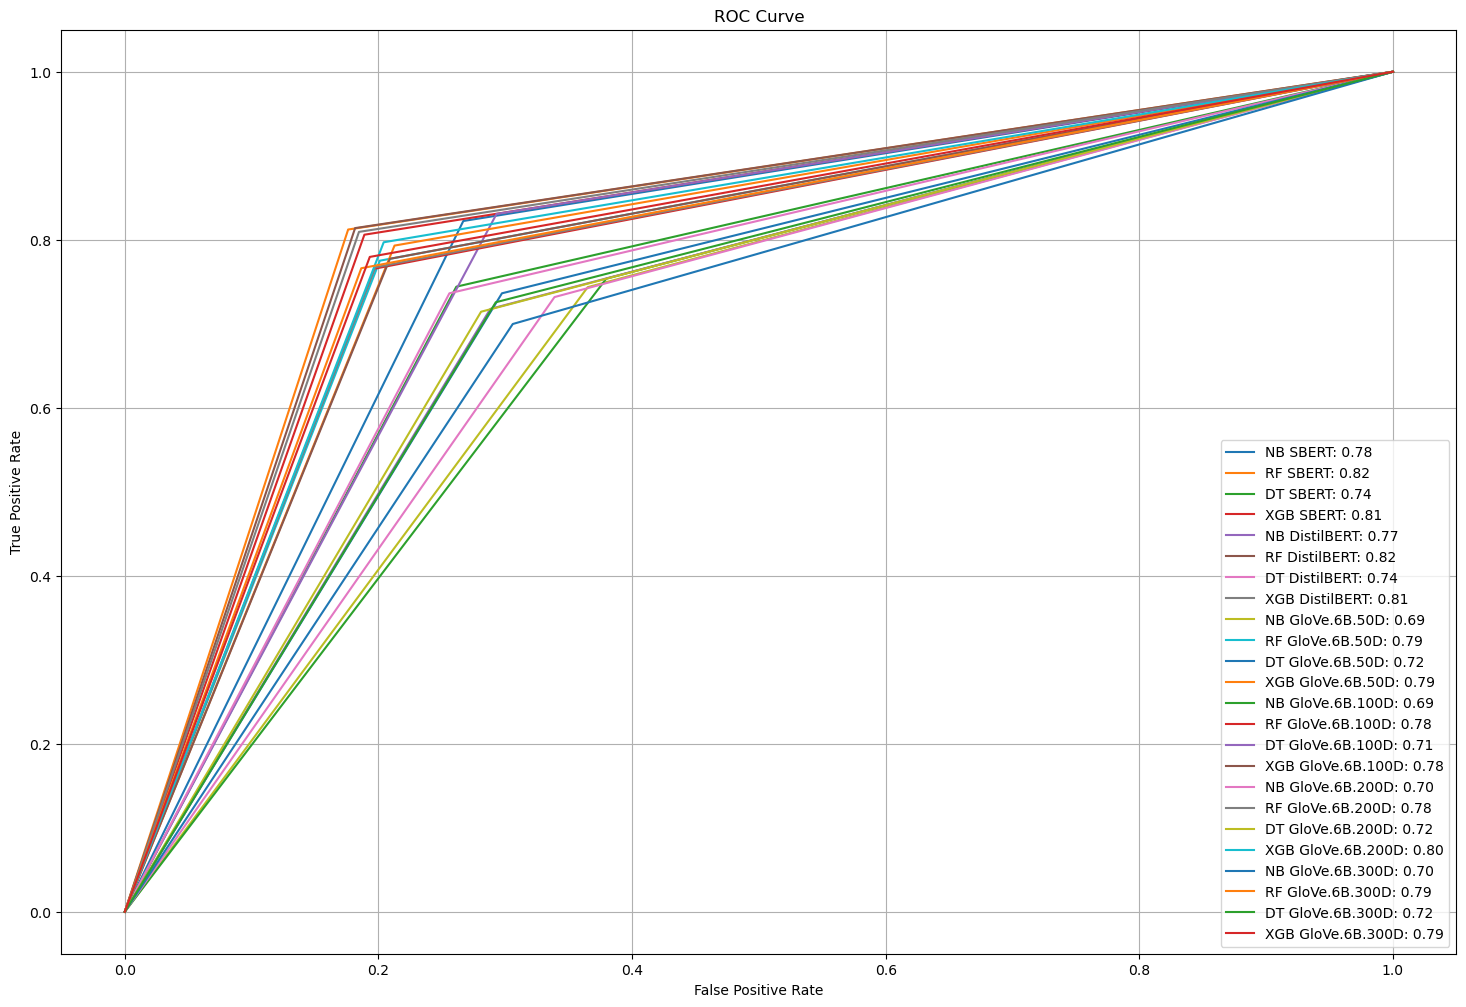

In [9]:
plt.figure(figsize=(18, 12))

for name, model_dict in models_dict.items():
    plt.plot(
        model_dict['test']['fpr'], model_dict['test']['tpr'],
        label=f"{name}: {model_dict['test']['auc']:.2f}"
    )

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
max_cv_score = 0.
optimal_model = None

for name, model in models_dict.items():
    if models_dict[name]['cv-accuracy'] > max_cv_score:
        max_cv_score = models_dict[name]['cv-accuracy']
        optimal_model = model
        optimal_model['name'] = name

optimal_model

{'cv-accuracy': 0.8177128190528344,
 'model': RandomForestClassifier(bootstrap=False, max_depth=15, min_samples_leaf=10,
                        min_samples_split=21, n_estimators=151, random_state=42),
 'train': {'accuracy': 0.948975765246332,
  'precision': 0.9592948258563853,
  'recall': 0.9412178315286176,
  'f1': 0.9501703577512777,
  'fpr': array([0.       , 0.0432663, 1.       ]),
  'tpr': array([0.        , 0.94121783, 1.        ]),
  'auc': 0.9489757652463319},
 'test': {'accuracy': 0.8180181773439197,
  'precision': 0.8332371609924986,
  'recall': 0.81214848143982,
  'f1': 0.8225576758758189,
  'fpr': array([0.        , 0.17611213, 1.        ]),
  'tpr': array([0.        , 0.81214848, 1.        ]),
  'auc': 0.8180181773439198},
 'name': 'RF SBERT'}

In [11]:
if OVERWRITE:
    joblib.dump(models_dict, MODELS_DICT_PKL, compress=9)

In [11]:
performances = DataFrame()
for i, name in zip(DataFrame(data=models_dict.values(), index=models_dict.keys())['train'], models_dict.keys()):
    performances[name] = DataFrame(data=i.values(), index=[c.upper() for c in i.keys()])

performances = performances.T.drop(labels=['FPR', 'TPR'], axis=1)
performances

,ACCURACY,PRECISION,RECALL,F1,AUC
NB SBERT,0.772518,0.762962,0.821544,0.79117,0.772518
RF SBERT,0.948976,0.959295,0.941218,0.95017,0.948976
DT SBERT,0.964081,0.976101,0.953452,0.964644,0.964081
XGB SBERT,0.963466,0.965241,0.964562,0.964901,0.963466
NB DistilBERT,0.761654,0.749294,0.820841,0.783437,0.761654
RF DistilBERT,0.952538,0.96221,0.945296,0.953678,0.952538
DT DistilBERT,0.965324,0.977256,0.954718,0.965856,0.965324
XGB DistilBERT,0.964111,0.968701,0.96189,0.965284,0.964111
NB GloVe.6B.50D,0.702966,0.69943,0.759527,0.728241,0.702966
RF GloVe.6B.50D,0.936917,0.946518,0.930811,0.938599,0.936917


In [12]:
performances = DataFrame()
for i, name in zip(DataFrame(data=models_dict.values(), index=models_dict.keys())['test'], models_dict.keys()):
    performances[name] = DataFrame(data=i.values(), index=[c.upper() for c in i.keys()])

performances = performances.T.drop(labels=['FPR', 'TPR'], axis=1)
performances

,ACCURACY,PRECISION,RECALL,F1,AUC
NB SBERT,0.777681,0.769474,0.822272,0.794997,0.777681
RF SBERT,0.818018,0.833237,0.812148,0.822558,0.818018
DT SBERT,0.741334,0.755137,0.744094,0.749575,0.741334
XGB SBERT,0.808526,0.822146,0.805962,0.813973,0.808526
NB DistilBERT,0.768797,0.754341,0.830709,0.790685,0.768797
RF DistilBERT,0.81612,0.829226,0.813836,0.821459,0.81612
DT DistilBERT,0.740139,0.757085,0.73622,0.746507,0.740139
XGB DistilBERT,0.812346,0.826062,0.809336,0.817614,0.812346
NB GloVe.6B.50D,0.689255,0.688183,0.743532,0.714788,0.689255
RF GloVe.6B.50D,0.786966,0.806792,0.775028,0.790591,0.786966


In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    preprocess_texts(
        list_str=texts,
        model_path='sentence-transformers/all-mpnet-base-v2',
        embedding_dim=None,
    ), target,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=target
)

In [21]:
def objective(params):
    clf = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']) if params['max_depth'] else None,
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],
        bootstrap=params['bootstrap'],
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    score = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': 1 - score, 'status': STATUS_OK}


space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30, 40, 50]),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(seed=RANDOM_STATE)
)

print("Best parameters:")
print(best)

100%|██████████| 100/100 [9:32:14<00:00, 343.34s/trial, best loss: 0.18500914076782438]   
Best parameters:
{'bootstrap': 1, 'max_depth': 4, 'max_features': 0, 'min_samples_leaf': 6.0, 'min_samples_split': 7.0, 'n_estimators': 280.0}


In [24]:
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': None if best['max_depth'] == 0 else [None, 10, 20, 30, 40, 50][best['max_depth']],
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'max_features': ['sqrt', 'log2', None][best['max_features']],
    'bootstrap': [True, False][best['bootstrap']]
}

final_clf = RandomForestClassifier(**best_params, n_jobs=-1, random_state=RANDOM_STATE)
final_clf.fit(x_train, y_train)

test_accuracy = final_clf.score(x_test, y_test)
print(f"\nTest Accuracy: {test_accuracy * 100:.4f}%")


Test Accuracy: 82.2170%


# Performance over Anastasia's Dataset


In [26]:
anastasia = read_csv(filepath_or_buffer=ANASTASIA_CSV)
anastasia = anastasia[anastasia['lang'] == 'en']
#estimator = models_dict['RF GloVe.6B.300D']['model']
anastasia['RF SBERT'] = final_clf.predict(X=preprocess_texts(
    list_str=anastasia[anastasia['lang'] == 'en']['full_text'],
    model_path='sentence-transformers/all-mpnet-base-v2',
    embedding_dim=None,
))

Accuracy of prediction over Anastasia's dataset is:	0.98


In [28]:
rf_accuracy = balanced_accuracy_score(
    y_true=anastasia['Related'],
    y_pred=anastasia['RF SBERT']
)
print(f"Accuracy of prediction over Anastasia's dataset is:\t{rf_accuracy * 100:.2f}")
print(classification_report(y_true=anastasia['Related'], y_pred=anastasia['RF SBERT']))

Accuracy of prediction over Anastasia's dataset is:	98.12
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5971
           1       0.99      0.98      0.99     16376

    accuracy                           0.98     22347
   macro avg       0.97      0.98      0.97     22347
weighted avg       0.98      0.98      0.98     22347



In [39]:
if OVERWRITE:
    joblib.dump(final_clf, OPTIMAL_MODEL_PKL, compress=9)

model = joblib.load(OPTIMAL_MODEL_PKL)
model

RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_leaf=6,
                       min_samples_split=7, n_estimators=280, n_jobs=-1,
                       random_state=42)

In [37]:
import pandas as pd

final_clf.predict(X=preprocess_texts(
    list_str=pd.Series(['I\'m studying computer security', 'That\'s a teardrop']),
    model_path='sentence-transformers/all-mpnet-base-v2',
    embedding_dim=None,
))

array([False, False])